In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [3]:
X, y = mnist['data'], mnist['target'] 

In [4]:
import matplotlib.pyplot as plt

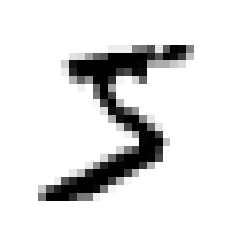

In [5]:
some_digit = X.iloc[0]
img = some_digit.values.reshape(28, 28)
plt.imshow(img, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0]

'5'

In [7]:
import numpy as np
y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_cls = SGDClassifier(random_state=42)
sgd_cls.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_cls.predict(some_digit.values.reshape(1, -1))

array([ True])

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_cls, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_ind, test_ind in skfolds.split(X_train, y_train_5):
    X_train_folds = X_train.iloc[train_ind]
    y_train_5_folds = y_train_5[train_ind]
    clone_sgd = clone(sgd_cls)
    X_test_fold = X_train.iloc[test_ind]
    y_test_fold = y_train_5[test_ind]
    
    clone_sgd.fit(X_train_folds, y_train_5_folds)
    y_preds = clone_sgd.predict(X_test_fold)
    n_correct = sum(y_preds == y_test_fold)
    print(n_correct / len(y_test_fold))


0.9669
0.91625
0.96785


In [14]:
from sklearn.base import BaseEstimator

class Not5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


In [15]:
not_5_clf = Not5Classifier()
cross_val_score(not_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [16]:
from sklearn.model_selection import cross_val_predict

y_pred_5 = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_pred_5)

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_pred_5)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_pred_5)

0.6511713705958311

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_pred_5)

0.7325171197343846

In [21]:
y_scores = sgd_cls.decision_function([some_digit])

In [22]:
threshold = 0
y_pred_custom = (y_scores > threshold)

In [23]:
y_pred_custom

array([ True])

In [24]:
threshold = 8000
y_pred_custom = (y_scores > threshold)
y_pred_custom

array([False])

In [25]:
y_scores = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3, method='decision_function')

In [26]:
from sklearn.metrics import precision_recall_curve

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [28]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    plt.show()


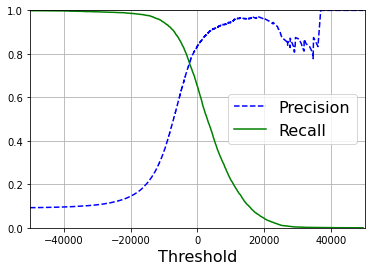

In [29]:
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)

In [30]:
threshold_90_p = thresholds[np.argmax(precisions >= 0.90)]

In [31]:
y_90_p_pred = (y_scores >= threshold_90_p)

In [32]:
precision_score(y_train_5, y_90_p_pred)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_90_p_pred)

0.4799852425751706

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [35]:
def plot_roc_curve(fpr, tpr, thresholds):
    plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.grid(True)


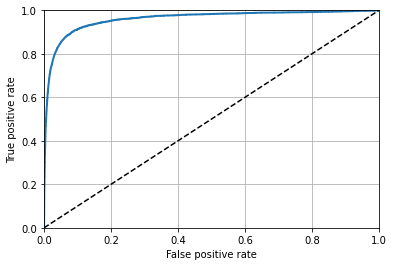

In [36]:
plot_roc_curve(fpr, tpr, thresholds)

In [37]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [38]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42)

In [39]:
forest_y_probas = cross_val_predict(rnd_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [40]:
forest_y_probas_5 = forest_y_probas[:, 1]

In [41]:
forest_fpr, forest_tpr, thresholds = roc_curve(y_train_5, forest_y_probas_5)

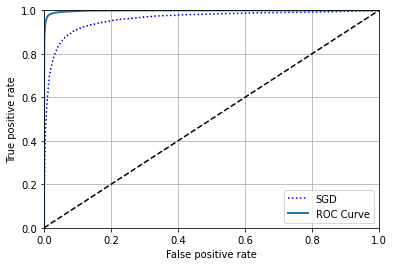

In [42]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(forest_fpr, forest_tpr, thresholds)
plt.legend(loc='lower right')
plt.show()

In [43]:
roc_auc_score(y_train_5, forest_y_probas_5)

0.9983436731328145

In [44]:
precision_score(y_train_5, forest_y_probas_5 > 0.50)

0.9905083315756169

In [45]:
recall_score(y_train_5, forest_y_probas_5 > 0.50)

0.8662608374838591

In [46]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [47]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
svm_clf.decision_function([some_digit])

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [49]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [51]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [52]:
len(ovr_clf.estimators_)

10

In [53]:
sgd_cls.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [54]:
sgd_cls.predict([some_digit])

array([3], dtype=uint8)

In [55]:
sgd_cls.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [56]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
sgd_clf = clone(sgd_cls)

In [58]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [59]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [60]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [62]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

In [63]:
X_train_scaled = std_scaler.fit_transform(X_train)

In [64]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [65]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [66]:
conf_mat = confusion_matrix(y_train, y_train_pred)

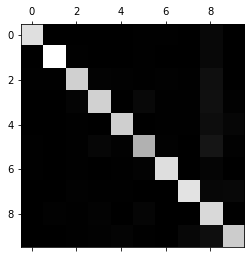

In [67]:
plt.matshow(conf_mat, cmap = plt.cm.gray)
plt.show()

In [68]:
row_sums = conf_mat.sum(axis=1, keepdims=True)

In [69]:
norm_conf_mat = conf_mat / row_sums

In [70]:
np.fill_diagonal(norm_conf_mat, 0)

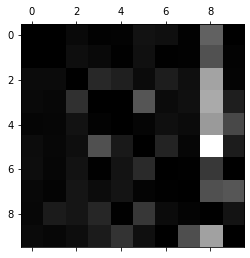

In [71]:
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()

In [72]:
import matplotlib as mpl
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


In [73]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

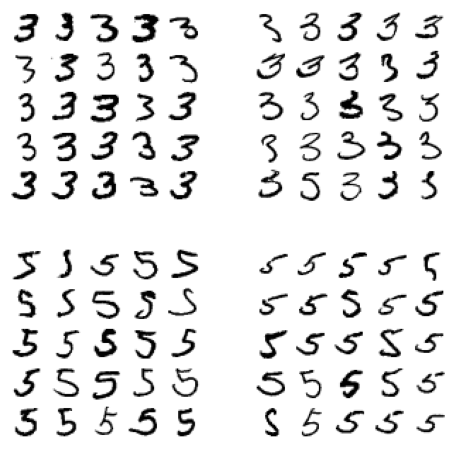

In [74]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25].to_numpy(), images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25].to_numpy(), images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25].to_numpy(), images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25].to_numpy(), images_per_row=5)
plt.show()

In [75]:
y_large = (y_train >= 7)

In [76]:
y_odd = (y_train % 2 == 1)

In [77]:
y_multiclass = np.c_[y_large, y_odd]

In [78]:
y_multiclass

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [79]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

In [80]:
knn_clf.fit(X_train, y_multiclass)

KNeighborsClassifier()

In [81]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [82]:
y_multiclass_knn_pred = cross_val_predict(knn_clf, X_train, y_multiclass, cv=3)

In [83]:
f1_score(y_multiclass, y_multiclass_knn_pred, average='macro')

0.976410265560605

In [84]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [85]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

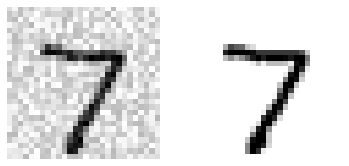

In [86]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index].values)
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index].values)
plt.show()

In [87]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [88]:
clean_image = knn_clf.predict([X_test_mod.iloc[some_index]])

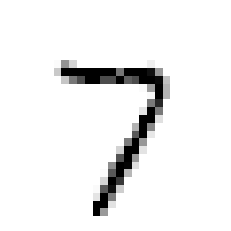

In [89]:
plot_digit(clean_image)

<h1>Exercises</h1>

## 1

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

param_grid = [{'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']}]

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .................n_neighbors=3, weights=uniform; total time=   9.9s
[CV 2/5] END .................n_neighbors=3, weights=uniform; total time=   9.8s
[CV 3/5] END .................n_neighbors=3, weights=uniform; total time=   9.9s
[CV 4/5] END .................n_neighbors=3, weights=uniform; total time=  10.8s
[CV 5/5] END .................n_neighbors=3, weights=uniform; total time=  10.1s
[CV 1/5] END ................n_neighbors=3, weights=distance; total time=   9.6s
[CV 2/5] END ................n_neighbors=3, weights=distance; total time=   9.3s
[CV 3/5] END ................n_neighbors=3, weights=distance; total time=   9.5s
[CV 4/5] END ................n_neighbors=3, weights=distance; total time=   9.3s
[CV 5/5] END ................n_neighbors=3, weights=distance; total time=   9.3s
[CV 1/5] END .................n_neighbors=4, weights=uniform; total time=  11.9s
[CV 2/5] END .................n_neighbors=4, weig

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [91]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [92]:
best_estimator = grid_search.best_estimator_

In [93]:
grid_search.best_score_

0.9716166666666666

In [94]:
y_pred_test = best_estimator.predict(X_test)

In [95]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_test)

0.9714

## 2

In [96]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])


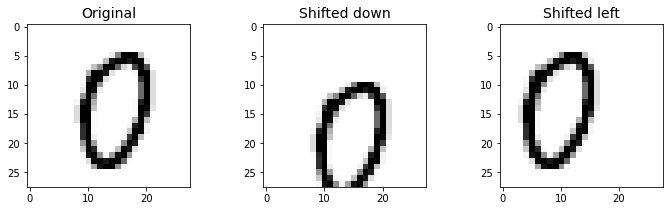

In [97]:
orig_image = X_train.iloc[1000].values
shifted_down_image = shift_image(orig_image, 0, 5)
shifted_left_image = shift_image(orig_image, -5, 0)
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('Original', fontsize=14)
plt.imshow(orig_image.reshape((28, 28)), cmap='Greys', interpolation='nearest')

plt.subplot(132)
plt.title('Shifted down', fontsize=14)
plt.imshow(shifted_down_image.reshape((28, 28)), cmap='Greys', interpolation='nearest')

plt.subplot(133)
plt.title('Shifted left', fontsize=14)
plt.imshow(shifted_left_image.reshape((28, 28)), cmap='Greys', interpolation='nearest')
plt.show()

In [98]:
X_train_arr = X_train.iloc[:].values
y_train_arr = y_train.iloc[:].values
X_train_aug = [image for image in X_train_arr]
y_train_aug = [label for label in y_train_arr]

for image, label in zip(X_train_arr, y_train_arr):
    for dx, dy in [(-1, 0), (1, 0),  (0, -1), (0, 1)]:
        X_train_aug.append(shift_image(image, dx, dy))
        y_train_aug.append(label)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

In [99]:
shuffle_idx = np.random.permutation(len(X_train_aug))
X_train_aug = X_train_aug[shuffle_idx]
y_train_aug = y_train_aug[shuffle_idx]

In [100]:
knn_clf_new = KNeighborsClassifier(**grid_search.best_params_)
knn_clf_new.fit(X_train_aug, y_train_aug)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [101]:
y_test_pred = knn_clf_new.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9763

## 3

In [114]:
import pandas as pd
df = pd.read_csv('titanic/train.csv', header=0)

In [115]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [123]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


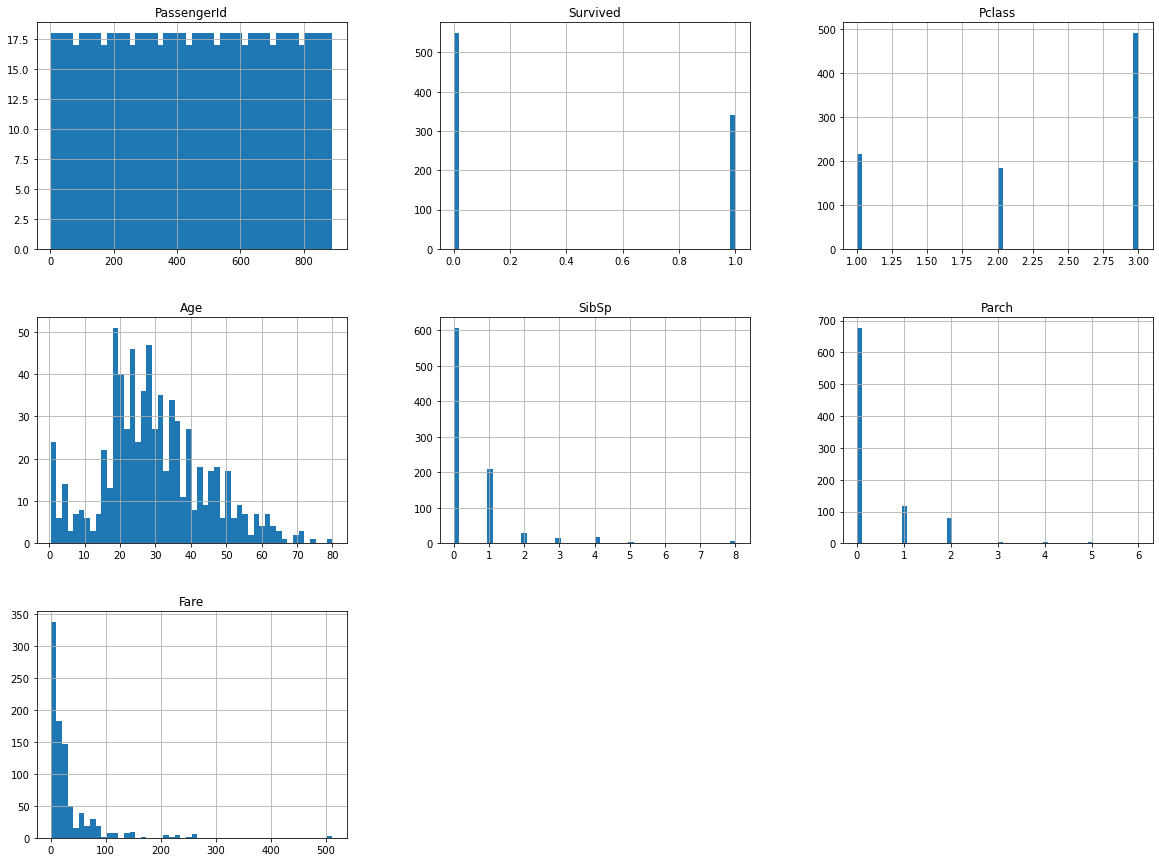

In [127]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [152]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
titanic_nm = df.drop(columns=['Name', 'PassengerId', 'Survived', 'Sex', 'Embarked', 'Cabin', 'Ticket'])
cols, index = titanic_nm.columns, titanic_nm.index
imputer.fit(titanic_nm)
titanic_nm = imputer.transform(titanic_nm)

In [153]:
X = pd.DataFrame(titanic_nm, columns=cols, index=index)
X

,Pclass,Age,SibSp,Parch,Fare
0,3.0,22.0,1.0,0.0,7.2500
1,1.0,38.0,1.0,0.0,71.2833
2,3.0,26.0,0.0,0.0,7.9250
3,1.0,35.0,1.0,0.0,53.1000
4,3.0,35.0,0.0,0.0,8.0500
...,...,...,...,...,...
886,2.0,27.0,0.0,0.0,13.0000
887,1.0,19.0,0.0,0.0,30.0000
888,3.0,28.0,1.0,2.0,23.4500
889,1.0,26.0,0.0,0.0,30.0000


In [202]:
titanic_cat = df[['Sex', 'Embarked']]
titanic_cat = titanic_cat[titanic_cat['Embarked'].notnull()]
titanic_cat

,Sex,Embarked
0,male,S
1,female,C
2,female,S
3,female,S
4,male,S
...,...,...
886,male,S
887,female,S
888,female,S
889,male,C


In [203]:
from sklearn.preprocessing import OneHotEncoder

one_h_encoder = OneHotEncoder()
titanic_cat = one_h_encoder.fit_transform(titanic_cat)

In [205]:
X_cat = pd.DataFrame(titanic_cat.toarray())

In [206]:
X_cat

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...
884,0.0,1.0,0.0,0.0,1.0
885,1.0,0.0,0.0,0.0,1.0
886,1.0,0.0,0.0,0.0,1.0
887,0.0,1.0,1.0,0.0,0.0


In [208]:
num_attribs = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Sex', 'Embarked']

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [216]:
titanic = df.drop(columns=['PassengerId', 'Name', 'Survived', 'Ticket', 'Cabin'])

In [217]:
num_attribs = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Sex', 'Embarked']

from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([
    ('nums', SimpleImputer(strategy='median'), num_attribs),
    ('cats', OneHotEncoder(), cat_attribs)
])

X = ct.fit_transform(titanic)

In [244]:
X = np.delete(X, X.shape[1]-1, 1)

In [254]:
y = df['Survived'].values

In [260]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

In [266]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [267]:
y_pred = lr_clf.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8044692737430168

In [268]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [270]:
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_pred_tree, y_test)

0.8212290502793296

In [273]:
test_data = pd.read_csv('titanic/test.csv', header=0)

In [274]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [275]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [276]:
X_test_data = ct.fit_transform(test_data)

In [279]:
y_pred_test_data = tree_clf.predict(X_test_data)

In [280]:
y_pred_test_data

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [284]:
final = np.c_[test_data['PassengerId'].values, y_pred_test_data]

In [285]:
submission = pd.DataFrame(final, columns=['PassengerId', 'Survived'])

In [290]:
submission.to_csv('titanic_submission.csv', index=False)

In [291]:
pd.read_csv('titanic_submission.csv')

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
